In [1]:
import os
from typing import Annotated, List, Tuple, Union
from typing_extensions import TypedDict
import operator

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import functools

import getpass
from dotenv import load_dotenv
load_dotenv(dotenv_path='../.env')

True

In [2]:
class AgentState(TypedDict):
    """State shared between all agents in the graph"""
    messages: Annotated[list, operator.add]
    next:str
    current_agent: str
    research_topic: str
    findings: dict
    final_report: str

class AgentResponse(TypedDict):
    """Standard response format for all agents"""
    content: str
    next_agent: str
    findings: dict

def create_llm(temperature: float=0.1, model:str='gemini-1.5-flash') -> ChatGoogleGenerativeAI:
    """Create a configured Gemini LLM instance"""
    return ChatGoogleGenerativeAI(
        model=model,
        temperature=temperature,
        google_api_key = os.getenv('GOOGLE_API_KEY')
    )

In [3]:
def create_research_agent(llm: ChatGoogleGenerativeAI) -> callable:
    """Create a research specialist agent for initial data gathering"""

    research_prompt = ChatPromptTemplate.from_messages([
        ("system",
        """
        You are a Research Specialist AI. Your role is to:
        1. Analyze the research topic thoroughly
        2. Identify key areas that need investigation
        3. Provide initial research findings and insights
        4. Suggest specific angles for deeper analysis

        Focus on providing comprehensive, accurate information and clear research directions.
        Always structure your response with clear sections and bullet points.
        """),
        MessagesPlaceholder(variable_name="messages"),
        ("human", "Research Topic: {research_topic}")
    ])

    research_chain = research_prompt | llm

    def research_agent(state:AgentState) -> AgentState:
        """Execute research analysis"""
        try:
            response = research_chain.invoke({
                "messages":state['messages'],
                "research_topic":state['research_topic']
            })

            findings = {
                "researtch_overview": response.content,
                "key_areas": ["area1","area2","area3"],
                "initial_insights": response.content[:500] + "..."
            }
            return {
                "messages": state['messages'] + [AIMessage(content=response.content)],
                "next":"analyst",
                "current_agent": "researcher",
                "research_topic": state["research_topic"],
                "findings": {**state.get("findings", {}), "research": findings},
                "final_report": state.get("final_report", "")
            }
        
        except Exception as e:
            error_msg = f"Research agent error : {str(e)}"
            return {
                "messages": state["messages"] + [AIMessage(content=error_msg)],
                "next": "analyst",
                "current_agent": "researcher",
                "research_topic": state["research_topic"],
                "findings": state.get("findings", {}),
                "final_report": state.get("final_report", "")
            }

    return research_agent



In [4]:
def create_analyst_agent(llm: ChatGoogleGenerativeAI) -> callable:
    """Creates a data analyst agent for deep analysis"""

    analyst_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Data Analyst AI. Your role is to:
        1. Analyze data and information provided by the research team
        2. Identify patterns, trends, and correlations
        3. Provide statistical insights and data-driven conclusions
        4. Suggest actionable recommendations based on analysis

        Focus on quantitative analysis, data interpretation, and evidence-based insights.
        Use clear metrics and concrete examples in your analysis.
        """),
        MessagesPlaceholder(variable_name="messages"),
        ("human", "Analyze the research findings for: {research_topic}")
    ])

    analyst_chain = analyst_prompt | llm

    def analyst_agent(state: AgentState) -> AgentState:
        """Execute data analysis"""
        try:
            response = analyst_chain.invoke({
                "messages": state["messages"],
                "research_topic": state["research_topic"]
            })

            analysis_findings = {
                "analysis_summary": response.content,
                "key_metrics": ["metric1", "metric2", "metric3"],
                "recommendations": response.content.split("recommendations:")[-1] if "recommendations:" in response.content.lower() else "No specific recommendations found"
            }

            return {
                "messages": state["messages"] + [AIMessage(content=response.content)],
                "next": "writer",
                "current_agent": "analyst",
                "research_topic": state["research_topic"],
                "findings": {**state.get("findings", {}), "analysis": analysis_findings},
                "final_report": state.get("final_report", "")
            }

        except Exception as e:
            error_msg = f"Analyst agent error: {str(e)}"
            return {
                "messages": state["messages"] + [AIMessage(content=error_msg)],
                "next": "writer",
                "current_agent": "analyst",
                "research_topic": state["research_topic"],
                "findings": state.get("findings", {}),
                "final_report": state.get("final_report", "")
            }

    return analyst_agent

In [5]:
def create_writer_agent(llm: ChatGoogleGenerativeAI) -> callable:
    """Creates a report writer agent for final documentation"""

    writer_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Report Writer AI. Your role is to:
        1. Synthesize all research and analysis into a comprehensive report
        2. Create clear, professional documentation
        3. Ensure proper structure with executive summary, findings, and conclusions
        4. Make complex information accessible to various audiences

        Focus on clarity, completeness, and professional presentation.
        Include specific examples and actionable insights.
        """),
        MessagesPlaceholder(variable_name="messages"),
        ("human", "Create a comprehensive report for: {research_topic}")
    ])

    writer_chain = writer_prompt | llm

    def writer_agent(state: AgentState) -> AgentState:
        """Execute report writing"""
        try:
            response = writer_chain.invoke({
                "messages": state["messages"],
                "research_topic": state["research_topic"]
            })

            return {
                "messages": state["messages"] + [AIMessage(content=response.content)],
                "next": "supervisor",
                "current_agent": "writer",
                "research_topic": state["research_topic"],
                "findings": state.get("findings", {}),
                "final_report": response.content
            }

        except Exception as e:
            error_msg = f"Writer agent error: {str(e)}"
            return {
                "messages": state["messages"] + [AIMessage(content=error_msg)],
                "next": "supervisor",
                "current_agent": "writer",
                "research_topic": state["research_topic"],
                "findings": state.get("findings", {}),
                "final_report": f"Error generating report: {str(e)}"
            }

    return writer_agent

In [6]:
def create_supervisor_agent(llm: ChatGoogleGenerativeAI, members: List[str]) -> callable:
    """Creates a supervisor agent to coordinate the team"""

    options = ["FINISH"] + members

    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a Supervisor AI managing a research team. Your team members are:
        {', '.join(members)}

        Your responsibilities:
        1. Coordinate the workflow between team members
        2. Ensure each agent completes their specialized tasks
        3. Determine when the research is complete
        4. Maintain quality standards throughout the process

        Given the conversation, determine the next step:
        - If research is needed: route to "researcher"
        - If analysis is needed: route to "analyst"
        - If report writing is needed: route to "writer"
        - If work is complete: route to "FINISH"

        Available options: {options}

        Respond with just the name of the next agent or "FINISH".
        """),
        MessagesPlaceholder(variable_name="messages"),
        ("human", "Current status: {current_agent} just completed their task for topic: {research_topic}")
    ])

    supervisor_chain = supervisor_prompt | llm

    def supervisor_agent(state: AgentState) -> AgentState:
        """Execute supervisor coordination"""
        try:
            response = supervisor_chain.invoke({
                "messages": state["messages"],
                "current_agent": state.get("current_agent", "none"),
                "research_topic": state["research_topic"]
            })

            next_agent = response.content.strip().lower()

            if "finish" in next_agent or "complete" in next_agent:
                next_step = "FINISH"
            elif "research" in next_agent:
                next_step = "researcher"
            elif "analy" in next_agent:
                next_step = "analyst"
            elif "writ" in next_agent:
                next_step = "writer"
            else:
                current = state.get("current_agent", "")
                if current == "researcher":
                    next_step = "analyst"
                elif current == "analyst":
                    next_step = "writer"
                elif current == "writer":
                    next_step = "FINISH"
                else:
                    next_step = "researcher"

            return {
                "messages": state["messages"] + [AIMessage(content=f"Supervisor decision: Next agent is {next_step}")],
                "next": next_step,
                "current_agent": "supervisor",
                "research_topic": state["research_topic"],
                "findings": state.get("findings", {}),
                "final_report": state.get("final_report", "")
            }

        except Exception as e:
            error_msg = f"Supervisor error: {str(e)}"
            return {
                "messages": state["messages"] + [AIMessage(content=error_msg)],
                "next": "FINISH",
                "current_agent": "supervisor",
                "research_topic": state["research_topic"],
                "findings": state.get("findings", {}),
                "final_report": state.get("final_report", "")
            }

    return supervisor_agent

In [7]:
def create_research_team_graph() -> StateGraph:
    """Creates the complete research team workflow graph"""

    llm = create_llm()

    members = ["researcher", "analyst", "writer"]
    researcher = create_research_agent(llm)
    analyst = create_analyst_agent(llm)
    writer = create_writer_agent(llm)

    supervisor = create_supervisor_agent(llm, members)

    workflow = StateGraph(AgentState)

    workflow.add_node("researcher", researcher)
    workflow.add_node("analyst", analyst)
    workflow.add_node("writer", writer)
    workflow.add_node("supervisor", supervisor)    

    workflow.add_edge('researcher', 'supervisor')
    workflow.add_edge('analyst', 'supervisor')
    workflow.add_edge('writer', 'supervisor')

    workflow.add_conditional_edges(
        'supervisor',
        lambda x:x['next'],
        {
            'researcher': 'researcher',
            'analyst': 'analyst',
            'writer': 'writer',
            "FINISH": END
        }
    )

    workflow.set_entry_point('supervisor')

    return workflow

def compile_research_team():
    """Compile the research team graph with memory"""
    workflow = create_research_team_graph()

    memory = MemorySaver()

    app = workflow.compile(checkpointer=memory)

    return app

In [8]:
def run_research_team(topic: str, thread_id: str = "research_session_1"):
    """Run the complete research team workflow"""

    app = compile_research_team()

    initial_state = {
        "messages": [HumanMessage(content=f"Research the topic: {topic}")],
        "research_topic": topic,
        "next": "researcher",
        "current_agent": "start",
        "findings": {},
        "final_report": ""
    }

    config = {"configurable": {"thread_id": thread_id}}

    print(f"🔍 Starting research on: {topic}")
    print("=" * 50)

    try:
        final_state = None
        for step, state in enumerate(app.stream(initial_state, config=config)):
            print(f"\n📍 Step {step + 1}: {list(state.keys())[0]}")

            current_state = list(state.values())[0]
            if current_state["messages"]:
                last_message = current_state["messages"][-1]
                if isinstance(last_message, AIMessage):
                    print(f"💬 {last_message.content[:200]}...")

            final_state = current_state

            if step > 10:
                print("⚠️  Maximum steps reached. Stopping execution.")
                break

        return final_state

    except Exception as e:
        print(f"❌ Error during execution: {str(e)}")
        return None

In [10]:
def visualize_graph():
    """Visualize the research team graph structure"""

    try:
        app = compile_research_team()

        graph_repr = app.get_graph()

        print("🗺️  Research Team Graph Structure")
        print("=" * 40)
        print(f"Nodes: {list(graph_repr.nodes.keys())}")
        print(f"Edges: {[(edge.source, edge.target) for edge in graph_repr.edges]}")

        try:
            graph_repr.draw_mermaid()
        except:
            print("📊 Visual graph requires mermaid-py package")
            print("Install with: !pip install mermaid-py")

    except Exception as e:
        print(f"❌ Error visualizing graph: {str(e)}")

visualize_graph()

🗺️  Research Team Graph Structure
Nodes: ['__start__', 'researcher', 'analyst', 'writer', 'supervisor', '__end__']
Edges: [('__start__', 'supervisor'), ('analyst', 'supervisor'), ('researcher', 'supervisor'), ('writer', 'supervisor'), ('supervisor', 'researcher'), ('supervisor', 'analyst'), ('supervisor', 'writer'), ('supervisor', '__end__')]


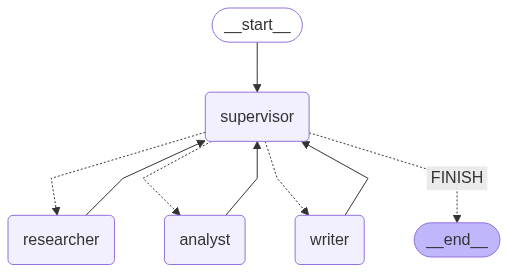

In [ ]:
from IPython.display import Image, display

def visualize_graph_img():
    """Visualize the research team graph structure"""

    try:  
        app = compile_research_team()
        display(Image(app.get_graph(xray=True).draw_mermaid_png()))
    
    except Exception as e:
        print(f"❌ Error visualizing graph: {str(e)}")

visualize_graph_img()

In [13]:
# result = run_research_team("Artificial Intelligence in Healthcare")
result = run_research_team("Importance of Fitness in modern life")

if result:
    print("\n"+"="*50)
    print("Final Results")
    print("="*50)
    print(f"🏁 Final Agent: {result['current_agent']}")
    print(f"📋 Findings: {len(result['findings'])} sections")
    print(f"📄 Report Length: {len(result['final_report'])} characters")

    if result['final_report']:
        if result['final_report']:
            print("\n📄 FINAL REPORT:")
            print("-" * 30)
            print(result['final_report'])

🔍 Starting research on: Importance of Fitness in modern life

📍 Step 1: supervisor
💬 Supervisor decision: Next agent is researcher...

📍 Step 2: researcher
💬 ## Research Topic: Importance of Fitness in Modern Life

This research topic is broad, encompassing physical, mental, and social aspects of fitness within the context of contemporary society.  To effe...

📍 Step 3: supervisor
💬 Supervisor decision: Next agent is analyst...

📍 Step 4: analyst
💬 Analyzing the importance of fitness in modern life requires synthesizing information from various research areas, including epidemiology, physiology, psychology, and sociology.  While a comprehensive ...

📍 Step 5: supervisor
💬 Supervisor decision: Next agent is writer...

📍 Step 6: writer
💬 ## The Importance of Fitness in Modern Life: A Comprehensive Report

**Executive Summary:**

This report examines the multifaceted importance of fitness in contemporary society.  It explores the signi...

📍 Step 7: supervisor
💬 Supervisor decision: Next 